### Importamos las librerías necesarias

In [59]:
from dotenv import load_dotenv
import mlflow
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, LearningCurveDisplay
import matplotlib.pyplot as plt
import os
import nbimporter

De la libreta `first_transform`, importamos la función `series_to_supervised` para poder transformar nuestro dataset en uno que pueda ser procesado por una regresión lineal:

In [6]:
from first_transform import series_to_supervised

### Cargando variables de entorno

Antes de comenzar, cargamos las variables de entorno necesarias para configurar `mlflow`. Las varibles se encuentran almacenadas en el archivo `.env`, por lo que es necesario configurarlas de antemano.
Para cargarlas, primero es necesario utilizar la función `load_dotenv`, seguido de `getenv` del módulo `os`:

In [7]:
load_dotenv()

True

In [8]:
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

### Cargando y preprocessando datos

Comenzando cargando nuestros datos procesados, para después pasarlos por la función `series_to_supervised` y así poderlos alimentar a nuestro modelo:

In [9]:
data = pd.read_csv('../data/processed/processed_data_energy.csv')

In [10]:
data.head()

,hora,dia,mes,anio,tmax-cab,tmax-hmo,tmax-obr,tmax-lmo,tmax-cul,tmin-cab,...,martes_postfestivo,semana_santa,1_mayo,10_mayo,16_sep,2_nov.,pre-navidad_y_new_year,navidad_y_new_year,post-navidad_y_new_year,demanda_energia
0,0,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1394
1,1,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1297
2,2,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1255
3,3,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1222
4,4,1,1,2007,21.0,22.0,25.0,30.0,29.0,2.0,...,0,0,0,0,0,0,0,1,0,1168


In [11]:
supervised_data = series_to_supervised(data[data.columns[4:]], n_in=12, n_out=1)

In [17]:
supervised_data.head()

,tmax-cab(t-12),tmax-hmo(t-12),tmax-obr(t-12),tmax-lmo(t-12),tmax-cul(t-12),tmin-cab(t-12),tmin-hmo(t-12),tmin-obr(t-12),tmin-lmo(t-12),tmin-cul(t-12),...,martes_postfestivo(t),semana_santa(t),1_mayo(t),10_mayo(t),16_sep(t),2_nov.(t),pre-navidad_y_new_year(t),navidad_y_new_year(t),post-navidad_y_new_year(t),demanda_energia(t)
12,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1079
13,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1086
14,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1083
15,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1073
16,21.0,22.0,25.0,30.0,29.0,2.0,9.0,8.0,10.0,9.0,...,0,0,0,0,0,0,0,1,0,1067


Una vez cargados y transformados los datos, podemos proceder a separarlos y con su preprocesamiento:

In [21]:
X = supervised_data.drop(columns=['demanda_energia(t)'])
y = pd.DataFrame(supervised_data['demanda_energia(t)'])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Una vez separados los datos, podemos proceder a su preprocesamiento, el cual en este caso consiste en una simple normalización.

In [25]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X_train)
y_scaled = scaler_y.fit_transform(y_train)

### Entrenando modelo sencillo (con mlflow)

Una vez hecho lo anterior, generamos nuestro modelo de regresión lineal:

Antes de ajustar nuestro modelo a los datos de entrenamiento, podemos generar las curvas de entrenamiento para observar el comportamiento de nuestro modelo con diferentes tamaños de datasets:

In [ ]:
lr_model = LinearRegression()

In [29]:
train_sizes, train_scores, test_scores = learning_curve(lr_model, X_scaled, y_scaled)

2024/05/21 23:10:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c46405ade8844d3ea332dc44c3ad9868', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/21 23:10:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/jesusg/anaconda3/envs/energy_prediction/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
2024/05/21 23:10:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8f149f8ded7c41ddb30c83d0e59e867b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024/05/21 23:10:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8a83bd5c7edc4a9ebb73d7b7e89c8d7e', which will track hyperparameters, performance metrics, model artifacts, and lineage inf

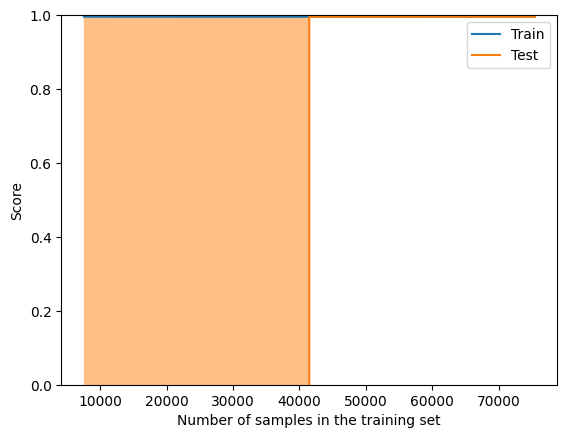

In [33]:
display = LearningCurveDisplay(train_sizes=train_sizes,
    train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.ylim([0,1])
plt.show()

Antes de comenzar a generar y entrenar nuestro modelo de aprendizaje automático, es necesario configurar el mlflow para indicarle donde se encuentra nuestro `remote`, recordemos que el URI se cargó anteriormente a partir del archivo `.env`.

Igualmente, activamos la función `autolog` para `sklearn` para que se haga un log de todas las métricas y entrenamientos que hagamos:

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.sklearn.autolog()

Una vez hecho lo anterior, generamos nuestro modelo de regresión lineal:

In [ ]:
lr_model = LinearRegression()

Una vez generada la curva de aprendizaje, podemos proceder a ajustar nuestro modelo a los datos de entrenamiento:

In [34]:
lr_model.fit(X_scaled, y_scaled)

2024/05/21 23:22:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'edd72bef579b484da626a2b519a7ab8a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


LinearRegression()

Antes de proceder a evaluar nuestro modelo con los datos de prueba, es necesario escalarlos de forma similar a los de entrenamiento:

In [43]:
X_test_scaled = scaler_x.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

In [53]:
y_pred = lr_model.predict(X_test_scaled)

In [51]:
lr_model.score(X_test_scaled, y_test_scaled)

0.9954397040721062

Antes de calcular las metricas de evaluación, y para una interpretación mas sencilla de las mismas, podemos hacer un escalamiento inverso en nuestras predicciones, para después proceder a calcular las métricas a partir de estos valores no escalados:

In [45]:
y_pred_unscaled = scaler_y.inverse_transform(y_pred)

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [61]:
mse = mean_squared_error(y_test, y_pred_unscaled)
print(f"El error cuadrado medio tiene un valor de {mse:.2f}")

El error cuadrado medio tiene un valor de 2893.57


In [62]:
mape = mean_absolute_percentage_error(y_test, y_pred_unscaled)
print(f"El MAPE tiene un valor de {mape:.2f}")

El MAPE tiene un valor de 0.02


In [67]:
mlflow.end_run()

In [68]:
with mlflow.start_run() as run: # Reemplazar con el valor del run a actualizar
    mlflow.log_metric("test_mean_absolute_percentage_error", mape)
    mlflow.log_metric("test_mean_squared_error", mse)

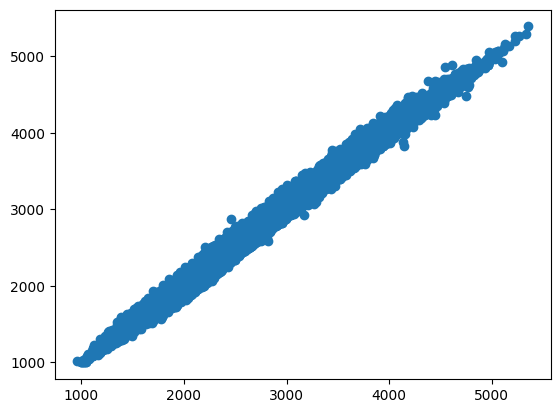

In [63]:
fig,ax = plt.subplots()
ax.scatter(y_pred_unscaled, y_test)